# L2, L1正則化（CIFAR10を用いた物体認識）

---
## 目的
畳み込みニューラルネットワーク (Convolutional Neural Network; CNN) を用いてCIFAR10データセットに対する物体認識を行う．
その際，L2正則化，L1正則化を用いることで，認識性能がどのように変化するかを確認する．

## 対応するチャプター
* 7.1.1: L2パラメータ正則化
* 7.1.2: L1正則化
* 8.1.3: バッチアルゴリズムとミニバッチアルゴリズム
* 8.3.1: 確率的勾配降下法
* 9.1: 畳み込み処理
* 9.3: プーリング


## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．
実験にはPythonの機械学習用ライブラリであるscikit-learnと深層学習ライブラリの一つであるchainerを使用します．
使用するクラス，関数は以下の通りです．

* `numpy`（説明は割愛）
* `load_breast_cancer`はデータセットを読み込むための関数
* `train_test_split`はデータを学習用とテスト用のデータに分割するための関数
* `chainer`は深層学習を使用するためのPythonライブラリ
* `chainer.cuda`はchainer上でGPUを使用した計算を行うためのモジュール

In [16]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

import chainer
from chainer.datasets import get_cifar10
from chainer import cuda
from chainer import Variable
import chainer.functions as F
import chainer.links as L
from chainer.optimizer_hooks import WeightDecay, Lasso

## GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU avilability: True`と表示されれば，GPUを使用した計算をChainerで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

In [2]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


## データセットの読み込み
CIFAR10データセットを読み込みます．

読み込んだ学習データのサイズを確認します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています．
これは32x32ピクセルのカラー画像という意味になります．

In [4]:
train_dataset, test_dataset = chainer.datasets.get_cifar10()
train_x,train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(50000, 3, 32, 32) (50000,)
(10000, 3, 32, 32) (10000,)


### CIFAR10データセットの表示
CIFAR10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

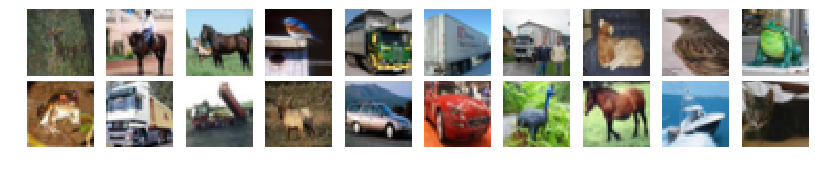

In [5]:
import matplotlib.pyplot as plt

cols = 10
rows = 2

plt.clf()
fig = plt.figure(figsize=(14, 4.8))
for r in range(rows):
    for c in range(cols):
        ax = fig.add_subplot(r+1, cols, c+1)
        ax.imshow(train_x[cols * r + c].transpose(1,2,0))
        ax.set_axis_off()
plt.show()

## ネットワークモデルの定義
畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層2層，全結合層3層から構成されるネットワークとします．

1層目の畳み込み層は入力チャンネル数が1，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．
2層目の畳み込み層は入力チャネル数が16，出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．
1つ目の全結合層は入力ユニット数は不定 (`None`) とし，出力は1024としています．
次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．
これらの各層の構成を`__init__`関数で定義します．

次に，`__call__`関数では，定義した層を接続して処理するように記述します．
`__call__`関数の引数`x`は入力データです．
それを`__init__`関数で定義した`conv1`に与え，その出力を活性化関数である`relu`関数に与えます．
そして，その出力を`max_pooling_2d`に入力して，プーリング処理結果を`h`として出力します．
`h`は`conv2`に与えられて畳み込み処理とプーリング処理を行います．
そして，出力`h`を`l1`に与えて全結合層の処理を行います．
最終的に`l3`の全結合層の処理を行った出力`h`を戻り値としています．

In [7]:
class CNN(chainer.Chain):
    def __init__(self):
        super(CNN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(3, 16, 3, pad=1)
            self.conv2 = L.Convolution2D(16, 32, 3, pad=1)
            self.l1 = L.Linear(None, 1024)
            self.l2 = L.Linear(1024, 1024)
            self.l3 = L.Linear(1024, 10)

    def __call__(self, x):
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．
ここでは，GPUで学習を行うために，modelをGPUに送るto_gpu関数を利用しています．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．また，学習率を0.05として引数に与えます．そして，最適化方法のsetup関数にネットワークモデルを与えます．


In [17]:
model = CNN()
model.to_gpu()

optimizer = chainer.optimizers.MomentumSGD(lr=0.05, momentum=0.9)
optimizer.setup(model)

# L2パラメータ正則化
# for param in model.params():
#     if param.name != 'b':                                # バイアス以外だったら
#         param.update_rule.add_hook(WeightDecay(0.0001))  # 重み減衰を適用
        
# L1正則化
for param in model.params():
    if param.name != 'b':                          # バイアス以外だったら
        param.update_rule.add_hook(Lasso(0.0001))  # 重み減衰を適用

ここでは，GPUに対応した行列演算モジュールのcupyを呼び出しており，学習およびテストデータをcupyの形式に変換します．
cupyはnumpyと互換性があります．


In [18]:
xp = cuda.cupy
train_x = xp.array(train_x, dtype=xp.float32)
train_y = xp.array(train_y, dtype=xp.int32)
test_x = xp.array(test_x, dtype=xp.float32)
test_y = xp.array(test_y, dtype=xp.int32)

## 学習
１回の誤差を算出するデータ数（ミニバッチサイズ）を64，学習エポック数を20とします．
CIFAR10の学習データサイズを取得し，1エポック内における更新回数を求めます．
学習データは毎エポックでランダムに利用するため，numpyの`permutation`という関数を利用します．
各更新において，学習用データと教師データをそれぞれ`x`と`t`とし，`to_gpu`関数でGPUに転送します．
学習モデルにxを与えて各クラスの確率`y`を取得します．
各クラスの確率`y`と教師ラベル`t`との誤差を`softmax_coross_entropy`誤差関数で算出します．
また，認識精度も算出します．
そして，誤差を`backward`関数で逆伝播し，ネットワークの更新を行います．

In [19]:
# ミニバッチサイズ・エポック数．学習データ数の設定
batch_size = 64
epoch_num = 20
train_data_num = train_x.shape[0]

# 学習の実行
start = time()
for epoch in range(1, epoch_num+1):
    
    num_iter = 0
    sum_loss = 0
    sum_accuracy = 0
    
    perm = xp.random.permutation(train_data_num)
    
    for i in range(0, train_data_num, batch_size):
        
        x = Variable(cuda.to_gpu(train_x[perm[i:i+batch_size]]))
        t = Variable(cuda.to_gpu(train_y[perm[i:i+batch_size]]))

        model.zerograds()        
        y = model(x)

        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        
        loss.backward()
        optimizer.update()
        
        sum_loss += loss.data
        sum_accuracy += acc.data
        num_iter +=1

    elapsed_time = time() - start
    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time: {}".format(epoch,
                                                                                 sum_loss/num_iter,
                                                                                 sum_accuracy/num_iter,
                                                                                 elapsed_time))

epoch: 1, mean loss: 1.6510575, mean accuracy: 0.39995605, elapsed_time: 7.190906524658203
epoch: 2, mean loss: 1.3055083, mean accuracy: 0.5394621, elapsed_time: 13.78432035446167
epoch: 3, mean loss: 1.1856513, mean accuracy: 0.5863371, elapsed_time: 20.452078580856323
epoch: 4, mean loss: 1.1141851, mean accuracy: 0.61528933, elapsed_time: 27.12953805923462
epoch: 5, mean loss: 1.06152, mean accuracy: 0.63287246, elapsed_time: 33.736785650253296
epoch: 6, mean loss: 1.0417223, mean accuracy: 0.6411645, elapsed_time: 40.31002140045166
epoch: 7, mean loss: 1.0085433, mean accuracy: 0.6535326, elapsed_time: 46.90249061584473
epoch: 8, mean loss: 0.9783152, mean accuracy: 0.6644421, elapsed_time: 53.51402473449707
epoch: 9, mean loss: 0.96949863, mean accuracy: 0.6665201, elapsed_time: 60.11541438102722
epoch: 10, mean loss: 0.94682485, mean accuracy: 0.673933, elapsed_time: 66.71273946762085
epoch: 11, mean loss: 0.9449971, mean accuracy: 0.6775096, elapsed_time: 73.6182153224945
epoch

## テスト
学習したネットワークモデルを用いて評価を行います．

In [21]:
cnt = 0
test_data_num = test_x.shape[0]

with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    for i in range(test_data_num):
        x = Variable(cuda.to_gpu(test_x[i].reshape(1,3,32,32)))
        t = test_y[i]
        y = model(x)
        y = np.argmax(y.data[0])
        if t == y:
            cnt += 1

print("test accuracy: {}".format(cnt/test_data_num))

test accuracy: 0.6572


## 課題
1. 正則化の有無で認識性能の変化を確認しましょう